In [154]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, silhouette_score, adjusted_rand_score, confusion_matrix
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.cluster import KMeans, OPTICS, MeanShift
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from platform import python_version

In [2]:
print(python_version())

3.8.5


In [3]:
mnist = fetch_openml('mnist_784') # already flatten

In [84]:
sample = np.random.randint(70000, size=10000)
data = mnist.data[sample]
target = mnist.target[sample]
data_df = pd.DataFrame(data)
data_df

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


0


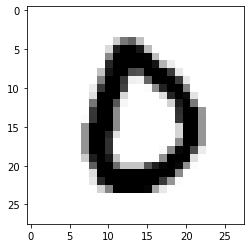

In [85]:
image = data_df.values[2].reshape((-1, 28, 28))
plt.imshow(image[0],cmap=plt.cm.gray_r,interpolation="nearest")
print(target[2])

In [86]:
norm_data = MinMaxScaler().fit_transform(data_df.values)
print(norm_data.shape)

(10000, 784)


In [87]:
# In order to not lose the original index we build a df
norm_data_df = pd.DataFrame(norm_data, index=data_df.index)

0


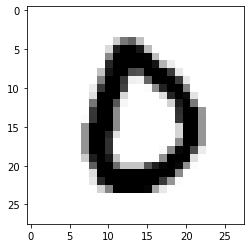

In [88]:
image_std = norm_data_df.values[2].reshape((-1, 28, 28))
plt.imshow(image_std[0],cmap=plt.cm.gray_r,interpolation="nearest")
print(target[2])

In [89]:
# 10 clusters
n_clusters = len(np.unique(target))
print('n_clusters detected = ', n_clusters)
kmeans = KMeans(
    n_clusters=n_clusters, 
    n_init=10,
    max_iter=2000,
    random_state=42
)
# Train K-Means.
kmeans.fit(norm_data_df.values)

n_clusters detected =  10


KMeans(max_iter=2000, n_clusters=10, random_state=42)

In [90]:
print('Kmeans fit result:')
print('inertia = ', kmeans.inertia_)
print('iterations to converge = ', kmeans.n_iter_ )

Kmeans fit result:
inertia =  393025.7606042176
iterations to converge =  31


In [91]:
print(kmeans.labels_)
print(target.astype(np.int))

[3 7 4 ... 9 6 8]
[3 7 0 ... 6 1 6]


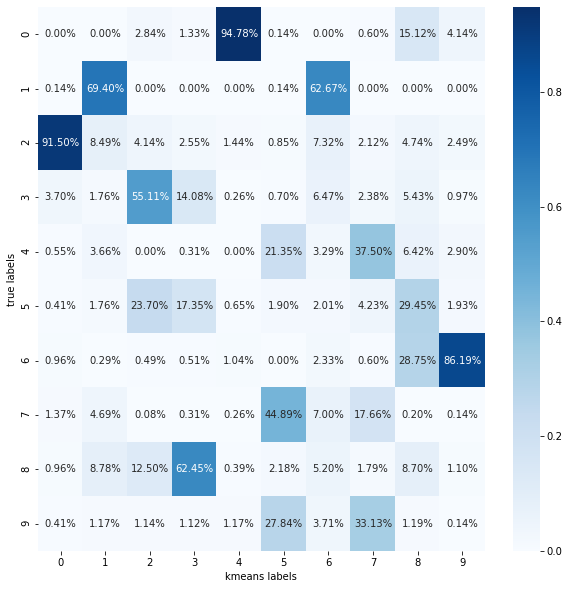

In [92]:
# We can see at the confusion matrix telling us the most frequent true class
cf_matrix = confusion_matrix(target.astype(np.int), kmeans.labels_)
plt.figure(figsize=(10,10))
sns.heatmap(cf_matrix / sum(cf_matrix), fmt = '.2%', annot=True, cmap='Blues')
plt.xlabel("kmeans labels")
plt.ylabel("true labels")
plt.show()

In [93]:
# Or use standard metrics for clusters:
print('homogeinity score = ', homogeneity_score(target.astype(np.int), kmeans.labels_))
print('completeness score = ', completeness_score(target.astype(np.int), kmeans.labels_))
print('v measure score = ', v_measure_score(target.astype(np.int), kmeans.labels_))

homogeinity score =  0.4949146121753622
completeness score =  0.5031633880769817
v measure score =  0.49900491345966996


In [94]:
# Because we are working with ~700 dimensions (num. of features), 
# it is not surprising that k-meancs cannot correctly cluster.
# What if we reduce the dimension with t-SNE ? (already proven to better perform w.r.t. PCA on MNIST)

In [95]:
# Let's try to have very separated clusters in 2D using t-SNE:
tsne = TSNE(n_components=2, random_state=42)

In [96]:
tsne_data = tsne.fit_transform(norm_data_df.values)
print(tsne_data)
tsne_DF = pd.DataFrame(data = tsne_data, columns = ['Dim 1', 'Dim 2'])

[[-37.801205   -14.5847845 ]
 [ 38.890015    63.408962  ]
 [-54.179813   -26.59232   ]
 ...
 [-20.531595   -77.410416  ]
 [ 46.93308      5.543286  ]
 [  0.82317597 -61.85631   ]]


In [97]:
tsne_DF_label = pd.concat([tsne_DF, pd.DataFrame(target, columns = ['true_label'])], axis = 1)
tsne_DF_label

,Dim 1,Dim 2,true_label
0,-37.801205,-14.584785,3
1,38.890015,63.408962,7
2,-54.179813,-26.592319,0
3,-19.109856,42.143963,9
4,2.998534,64.060303,4
...,...,...,...
9995,25.731623,-56.455135,2
9996,25.921917,-61.895512,2
9997,-20.531595,-77.410416,6
9998,46.933079,5.543286,1


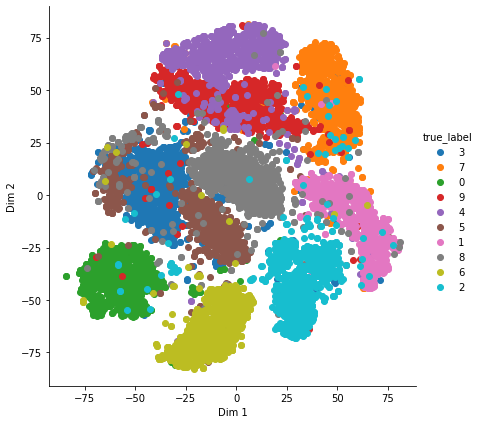

In [98]:
sns.FacetGrid(tsne_DF_label, hue="true_label", height=6).map(plt.scatter, 'Dim 1', 'Dim 2').add_legend()
plt.show()

In [99]:
kmeans.fit(tsne_DF.values)

KMeans(max_iter=2000, n_clusters=10, random_state=42)

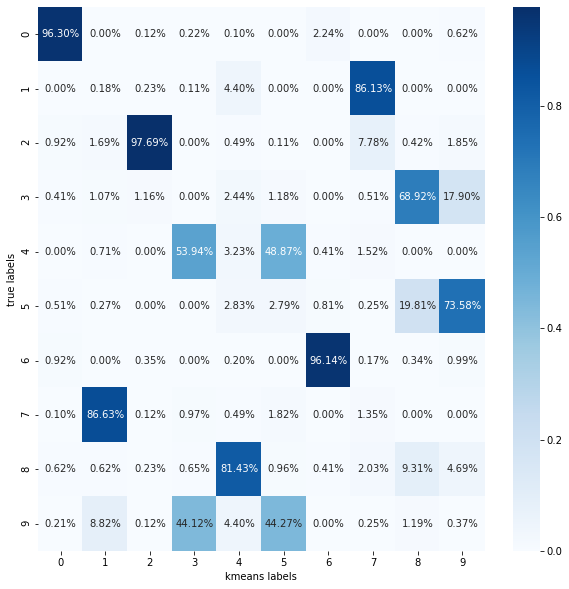

In [100]:
cf_matrix = confusion_matrix(target.astype(np.int), kmeans.labels_)
plt.figure(figsize=(10,10))
sns.heatmap(cf_matrix / sum(cf_matrix), fmt = '.2%', annot=True, cmap='Blues')
plt.xlabel("kmeans labels")
plt.ylabel("true labels")
plt.show()

In [101]:
print('homogeinity score = ', homogeneity_score(target.astype(np.int), kmeans.labels_))
print('completeness score = ', completeness_score(target.astype(np.int), kmeans.labels_))
print('v measure score = ', v_measure_score(target.astype(np.int), kmeans.labels_))

homogeinity score =  0.7348706222485493
completeness score =  0.7369014442336225
v measure score =  0.7358846321280912


In [102]:
# We improved but the clusters are still very overlapped and anisotropic
# Let's see if kmeans++ performs better:
kmeans_plus = KMeans(
    init='k-means++',
    n_clusters=n_clusters, 
    n_init=10,
    max_iter=2000,
    random_state=42
)

In [103]:
kmeans_plus.fit(tsne_DF.values)

KMeans(max_iter=2000, n_clusters=10, random_state=42)

In [104]:
print('homogeinity score = ', homogeneity_score(target.astype(np.int), kmeans_plus.labels_))
print('completeness score = ', completeness_score(target.astype(np.int), kmeans_plus.labels_))
print('v measure score = ', v_measure_score(target.astype(np.int), kmeans_plus.labels_))

homogeinity score =  0.7348706222485493
completeness score =  0.7369014442336225
v measure score =  0.7358846321280912


In [105]:
# not really...

In [117]:
# Let's increase the perplexity
tsne_boosted = TSNE(
    n_components=2,
    early_exaggeration=20,
    learning_rate=100,
    perplexity=50,
    n_iter=2000, 
    n_iter_without_progress=1000,
    random_state=42
)

In [118]:
tsne_boost_data = tsne_boosted.fit_transform(norm_data_df.values)
print(tsne_boost_data)
tsne_boost_DF = pd.DataFrame(data = tsne_boost_data, columns = ['Dim 1', 'Dim 2'])

[[ -23.784649  -15.875709]
 [  82.67003    24.214949]
 [ -55.168022  -39.732517]
 ...
 [-101.114586   -4.821577]
 [  13.227032  -29.102898]
 [ -80.39532   -21.829044]]


In [119]:
tsne_boost_DF_label = pd.concat([tsne_boost_DF, pd.DataFrame(target, columns = ['true_label'])], axis = 1)
tsne_boost_DF_label

,Dim 1,Dim 2,true_label
0,-23.784649,-15.875709,3
1,82.670029,24.214949,7
2,-55.168022,-39.732517,0
3,24.075598,55.572983,9
4,42.953217,15.505143,4
...,...,...,...
9995,-10.551625,-57.890110,2
9996,-13.423459,-52.423187,2
9997,-101.114586,-4.821577,6
9998,13.227032,-29.102898,1


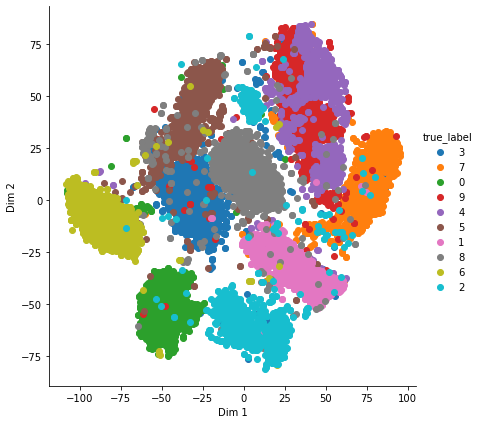

In [120]:
sns.FacetGrid(tsne_boost_DF_label, hue="true_label", height=6).map(plt.scatter, 'Dim 1', 'Dim 2').add_legend()
plt.show()

In [121]:
kmeans.fit(tsne_boost_DF.values)

KMeans(max_iter=2000, n_clusters=10, random_state=42)

In [122]:
print('Kmeans fit result:')
print('inertia = ', kmeans.inertia_)
print('iterations to converge = ', kmeans.n_iter_ )

Kmeans fit result:
inertia =  2740140.0
iterations to converge =  28


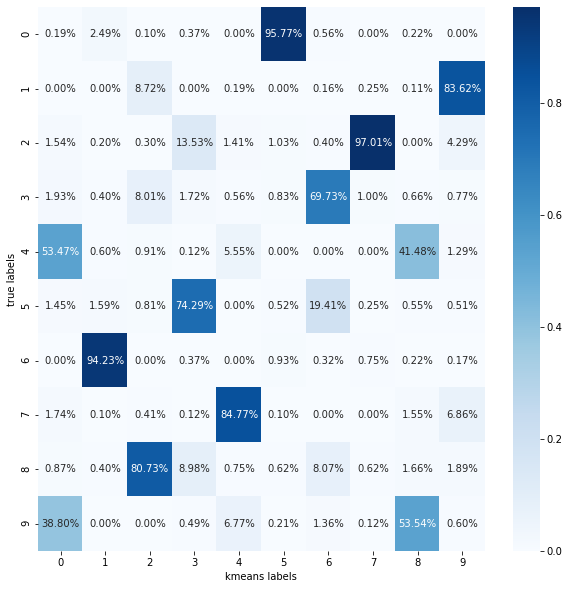

In [123]:
cf_matrix = confusion_matrix(target.astype(np.int), kmeans.labels_)
plt.figure(figsize=(10,10))
sns.heatmap(cf_matrix / sum(cf_matrix), fmt = '.2%', annot=True, cmap='Blues')
plt.xlabel("kmeans labels")
plt.ylabel("true labels")
plt.show()

In [124]:
print('homogeinity score = ', homogeneity_score(target.astype(np.int), kmeans.labels_))
print('completeness score = ', completeness_score(target.astype(np.int), kmeans.labels_))
print('v measure score = ', v_measure_score(target.astype(np.int), kmeans.labels_))

homogeinity score =  0.711838291339373
completeness score =  0.7143291831244661
v measure score =  0.7130815619818188


In [130]:
centroids = kmeans.cluster_centers_
centroids

array([[ 33.97088  ,  61.636982 ],
       [-84.21747  ,  -8.136302 ],
       [  2.9595323,   6.826059 ],
       [-21.482565 ,  46.823742 ],
       [ 72.78053  ,   6.8636093],
       [-46.388702 , -52.119087 ],
       [-36.137028 ,   5.684235 ],
       [  4.0260825, -60.397636 ],
       [ 43.52202  ,  27.768833 ],
       [ 32.12544  , -31.74416  ]], dtype=float32)

In [131]:
xc, yc = centroids.T

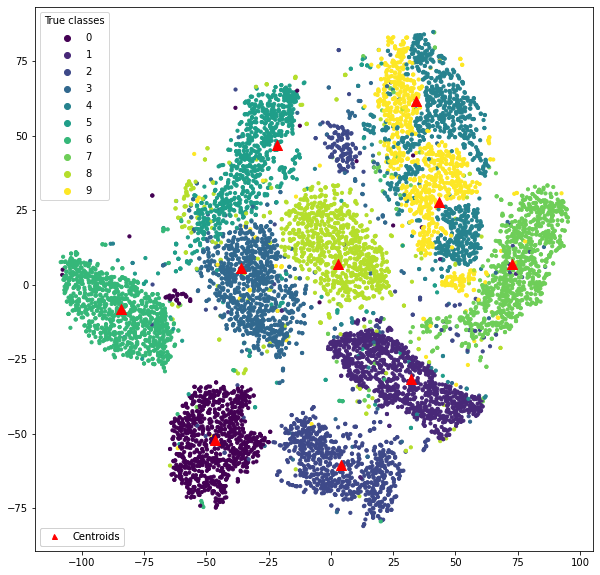

In [132]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)

data = ax1.scatter(tsne_boost_DF['Dim 1'], tsne_boost_DF['Dim 2'], s=10, c=target.astype(np.int), marker="o", label='data')
legend_data = ax1.legend(*data.legend_elements(), loc="upper left", title="True classes")
cent = ax1.scatter(xc, yc, s=100, c='r', marker="^", label='centroids')
red_dot = mlines.Line2D([], [], color='red', marker='^', linestyle='None', markersize=5, label='Centroids')
legend_cent = plt.legend(handles=[red_dot], loc='lower left')
ax1.add_artist(legend_data)
ax1.add_artist(legend_cent)
plt.show()

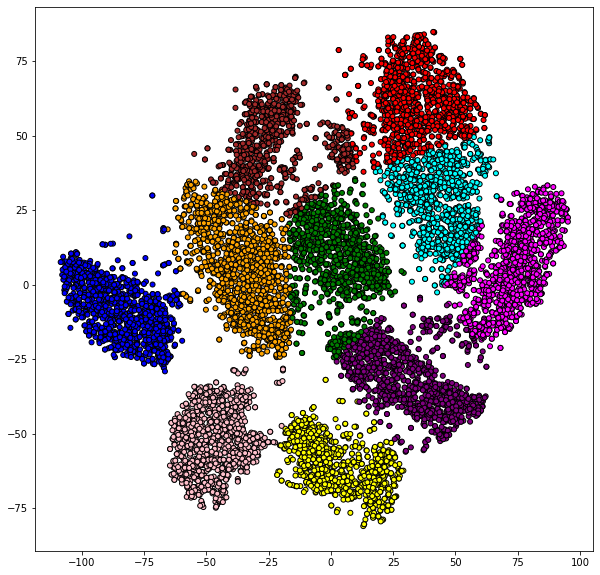

In [133]:
# Let's plot the clusters as labeled by kmeans:
fte_colors = {
    0:'red', 
    1:'blue', 
    2:'green', 
    3:'brown',
    4:'magenta',
    5:'pink',
    6:'orange',
    7:'yellow',
    8:'cyan',
    9:'purple',
}
km_colors = [fte_colors[label] for label in kmeans.labels_]
#ax1.scatter(scaled_features[:, 0], scaled_features[:, 1], c=km_colors)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(
    #scaled_features[:, 0], 
    #scaled_features[:, 1], 
    tsne_boost_DF['Dim 1'],
    tsne_boost_DF['Dim 2'],
    marker='o',
    c=km_colors,
    s=25, 
    edgecolor='k'
)
plt.show()